In [127]:
# Import necessary libraries
import cdflib
import xarray as xr
import os
# import urllib.request
import numpy as np
import pandas as pd
# import datetime as dt
from tqdm import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
# import math
# from scipy.signal import argrelextrema

import sys
# import glob
sys.path.append('../../SAMI3-GITM-python')
from utility_programs import filters
from utility_programs.read_routines import SAMI, GITM
# import SAMI3_ESMF_Regrid

# import h5py
# import dask
# from scipy.signal import savgol_filter
# from scipy.interpolate import CubicSpline
# import h5netcdf
# import flox
import importlib as il 
import ecef_geodetic
# import csv



from scipy.signal import find_peaks

In [25]:
fname = ['GR_OPER_TEC1TMS_2F_20130316T000000_20130316T235959_0101.cdf', 
         'GR_OPER_TEC1TMS_2F_20130317T000000_20130317T235959_0101.cdf', 
         'GR_OPER_TEC1TMS_2F_20130318T000000_20130318T235959_0101.cdf', 
         'GR_OPER_TEC2TMS_2F_20130316T000000_20130316T235959_0101.cdf', 
         'GR_OPER_TEC2TMS_2F_20130317T000000_20130317T235959_0101.cdf', 
         'GR_OPER_TEC2TMS_2F_20130318T000000_20130318T235959_0101.cdf']
grace = []


# Adding the local time
# ecef_geodetic = il.reload(ecef_geodetic)


for f in tqdm(fname):
    path = 'ESA_GRACE_data/' + f
    data = xr.Dataset()
    d = cdflib.CDF(path)

    step = range(len(d['Timestamp']))
    
    for var_name in d.cdf_info().zVariables:
        
        var_data = d[var_name]

        if var_name == 'DCB' or var_name == 'DCB_Error' :
            data[var_name] = d[var_name]
        
        elif type(var_data[0]) == np.ndarray:
            var_name1 = var_name + '_X'
            var_name2 = var_name + '_Y'
            var_name3 = var_name + '_Z'
            data[var_name1] = ('step', [i for i,j,k in var_data], {'step': step})
            data[var_name2] = ('step', [j for i,j,k in var_data], {'step': step})
            data[var_name3] = ('step', [k for i,j,k in var_data], {'step': step})

        else:
            data[var_name] = ('step', var_data, {'step': step})


    d0 = pd.Timestamp(f.split('_')[-2])
    date = [d0 + pd.Timedelta(milliseconds = (i - data.Timestamp[0].values)) for i in data.Timestamp.values]
    data['date'] = ('step', [i for i in date], {'step': step})
    lt = ecef_geodetic.ut_to_lt(date, data['Longitude'].values)
    data['LT'] = ('step', lt, {'step':step})
    
    grace.append(data)

print('Columns in Satellite Data: \n', data.data_vars, '\n\n')
data

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:32<00:00,  5.34s/it]

Columns in Satellite Data: 
 Data variables:
    Timestamp          (step) float64 454kB 6.353e+13 6.353e+13 ... 6.353e+13
    Latitude           (step) float64 454kB -60.57 -60.57 -60.57 ... 26.16 26.16
    Longitude          (step) float64 454kB -175.0 -175.0 -175.0 ... 2.732 2.732
    Radius             (step) float64 454kB 6.825e+06 6.825e+06 ... 6.822e+06
    GPS_Position_X     (step) float64 454kB -3.798e+06 -1.924e+07 ... 2.534e+07
    GPS_Position_Y     (step) float64 454kB -1.475e+07 1.345e+07 ... -7.897e+06
    GPS_Position_Z     (step) float64 454kB -2.178e+07 -1.3e+07 ... 3.192e+06
    LEO_Position_X     (step) float64 454kB -3.341e+06 -3.341e+06 ... 6.117e+06
    LEO_Position_Y     (step) float64 454kB -2.906e+05 -2.906e+05 ... 2.918e+05
    LEO_Position_Z     (step) float64 454kB -5.944e+06 -5.944e+06 ... 3.008e+06
    PRN                (step) uint16 113kB 1 9 24 32 1 9 ... 18 21 25 29 30 31
    L1                 (step) float64 454kB 2.145e+07 2.21e+07 ... 2.08e+07
    

<xarray.Dataset> Size: 11MB
Dimensions:            (step: 56708)
Dimensions without coordinates: step
Data variables: (12/26)
    Timestamp          (step) float64 454kB 6.353e+13 6.353e+13 ... 6.353e+13
    Latitude           (step) float64 454kB -60.57 -60.57 -60.57 ... 26.16 26.16
    Longitude          (step) float64 454kB -175.0 -175.0 -175.0 ... 2.732 2.732
    Radius             (step) float64 454kB 6.825e+06 6.825e+06 ... 6.822e+06
    GPS_Position_X     (step) float64 454kB -3.798e+06 -1.924e+07 ... 2.534e+07
    GPS_Position_Y     (step) float64 454kB -1.475e+07 1.345e+07 ... -7.897e+06
    ...                 ...
    Relative_STEC      (step) float64 454kB 86.47 56.26 80.43 ... 52.91 37.42
    Relative_STEC_RMS  (step) float64 454kB 0.7086 0.8702 ... 0.6698 0.2849
    DCB                float64 8B -39.28
    DCB_Error          float64 8B 0.9034
    date               (step) datetime64[ns] 454kB 2013-03-18T23:59:59 ... 20...
    LT                 (step) float64 454kB 12.33 12.33 12.33 ... 0.1735 0.1735

In [167]:
# Flat data - convert it to a Pandas DataFrame

# Concat the list of xr Datasets, converting each to Pandas as we go
df = pd.concat([i.to_pandas() for i in grace[:3]]).sort_values('date')

# Only select columns I care about - drop the index too (step doesn't matter so also reset the index of the df)
df = df[['Timestamp', 'GPS_Position_X', 
       'GPS_Position_Y', 'GPS_Position_Z', 'LEO_Position_X', 'LEO_Position_Y',
       'LEO_Position_Z', 'PRN', 'Latitude', 'Longitude',
       'Absolute_STEC', 'Elevation_Angle', 'date', 'LT']].reset_index(drop=True)

In [168]:
df.columns

Index(['Timestamp', 'GPS_Position_X', 'GPS_Position_Y', 'GPS_Position_Z',
       'LEO_Position_X', 'LEO_Position_Y', 'LEO_Position_Z', 'PRN', 'Latitude',
       'Longitude', 'Absolute_STEC', 'Elevation_Angle', 'date', 'LT'],
      dtype='object')

array([11, 12, 14, 18, 25, 31, 21, 30,  6, 16, 29,  3,  5, 13,  7, 10, 26,
        2,  8,  4,  9, 28, 17, 20, 32, 22, 19, 15, 23], dtype=uint16)

(Timestamp('2013-03-16 23:59:59'), Timestamp('2013-03-19 23:59:29'))

### Note
- LEO_Position given in the data are the positions of the GRACE satellite in the ECEF cartesian system (WGS84 is being used) and units are in meters
- GPS_Position given in the data are the positions of the GPS satellites
- Latitude, Longitude, and Radius represent the position of the GRACE satellite and they are in the spherical coordinates system (Geocentric or ECEF spherical system)
- Absolute VTEC is recommended to be calculated by using GPS rays of elevation angle as at least 50 degrees (in documentation).
- `grace` is having the raw data for different dates, `grace_data` is having filtered data (only elevation angle >= 50 is present)

In [173]:
df17 = df.iloc[np.where((df.date > pd.Timestamp('20130317')) & (df.date < pd.Timestamp('20130318')))].reset_index(drop=True)

In [174]:
df17

,Timestamp,GPS_Position_X,GPS_Position_Y,GPS_Position_Z,LEO_Position_X,LEO_Position_Y,LEO_Position_Z,PRN,Latitude,Longitude,Absolute_STEC,Elevation_Angle,date,LT
0,6.353061e+13,9.189751e+05,-1.838481e+07,-1.950535e+07,3.784929e+06,261950.319513,-5.683121e+06,11,-56.273411,3.959058,5.606099,23.147612,2013-03-17 00:00:09,0.266437
1,6.353061e+13,9.556340e+06,2.259664e+07,-1.046003e+07,3.784929e+06,261950.319513,-5.683121e+06,12,-56.273411,3.959058,5.549186,19.919115,2013-03-17 00:00:09,0.266437
2,6.353061e+13,1.660544e+07,-4.417388e+06,-2.001968e+07,3.784929e+06,261950.319513,-5.683121e+06,14,-56.273411,3.959058,3.970444,72.193156,2013-03-17 00:00:09,0.266437
3,6.353061e+13,2.079279e+07,1.435421e+07,-8.353860e+06,3.784929e+06,261950.319513,-5.683121e+06,18,-56.273411,3.959058,7.941035,33.199404,2013-03-17 00:00:09,0.266437
4,6.353061e+13,2.079754e+07,1.436476e+07,-8.325554e+06,3.847988e+06,265829.956549,-5.640487e+06,18,-55.634338,3.951877,8.017482,33.658713,2013-03-17 00:00:19,0.268736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55078,6.353070e+13,-1.877683e+07,-1.001140e+06,1.862374e+07,-1.049477e+05,107897.668432,6.804053e+06,10,88.732713,134.205954,9.850658,33.112100,2013-03-17 23:59:59,8.946786
55079,6.353070e+13,-7.240491e+06,-1.616314e+07,1.961249e+07,-1.049477e+05,107897.668432,6.804053e+06,13,88.732713,134.205954,6.584544,35.302757,2013-03-17 23:59:59,8.946786
55080,6.353070e+13,7.267546e+06,-1.368880e+07,2.150432e+07,-1.049477e+05,107897.668432,6.804053e+06,16,88.732713,134.205954,6.311253,42.001852,2013-03-17 23:59:59,8.946786
55081,6.353070e+13,-2.612183e+06,-2.246419e+07,1.366930e+07,-1.049477e+05,107897.668432,6.804053e+06,23,88.732713,134.205954,10.981010,16.011650,2013-03-17 23:59:59,8.946786


<Axes: xlabel='date'>

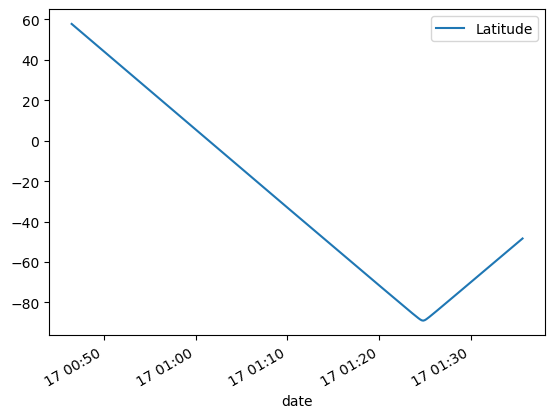

In [175]:
df.iloc[1738:3694].plot(x='date', y='Latitude')

In [110]:
d17 = grace[1]

latitude = list(d17.Latitude.values)

a = 0
b = 1000

c = 1000
d = 2000

maxi_lat = []
mini_lat = []

i = 0
c = 1

orbits = []
orbit_num = []
min_last = 0

while(i+3600 < len(latitude)):
    m = max(latitude[i: i +3600])
    mi = min(latitude[i: i +3600])
    
    if min_last != 0:
        orbits.append([min_last, latitude.index(m)])
        
    orbits.append([latitude.index(m), latitude.index(mi)])
    min_last = latitude.index(mi)
    i += 3600
    orbit_num.append(c)
    orbit_num.append(c)
    c += 1

print(orbits)
print(orbit_num)

[[0, 1738], [1738, 3694], [3694, 5399], [5399, 7224], [7224, 8962], [8962, 10883], [10883, 12666], [12666, 14495], [14495, 16329], [16329, 18110], [18110, 20127], [20127, 21888], [21888, 23755], [23755, 25540], [25540, 27270], [27270, 29070], [29070, 30796], [30796, 32829], [32829, 34370], [34370, 36294], [36294, 38046], [38046, 39935], [39935, 41535], [41535, 46706], [46706, 45128], [45128, 50131], [50131, 48471], [48471, 53418], [53418, 51863]]
[1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15]


2013-03-17 00:00:09 2013-03-17 00:46:39
2013-03-17 00:46:39 2013-03-17 01:35:39
2013-03-17 01:35:49 2013-03-17 02:14:49
2013-03-17 02:14:49 2013-03-17 03:09:39
2013-03-17 03:09:39 2013-03-17 03:49:19
2013-03-17 03:49:19 2013-03-17 04:41:39
2013-03-17 04:41:39 2013-03-17 05:28:49
2013-03-17 05:28:49 2013-03-17 06:17:19
2013-03-17 06:17:19 2013-03-17 07:04:29
2013-03-17 07:04:29 2013-03-17 07:48:29
2013-03-17 07:48:29 2013-03-17 08:42:59
2013-03-17 08:42:59 2013-03-17 09:30:19
2013-03-17 09:30:19 2013-03-17 10:16:09
2013-03-17 10:16:09 2013-03-17 11:05:39
2013-03-17 11:05:39 2013-03-17 11:47:19
2013-03-17 11:47:19 2013-03-17 12:38:39
2013-03-17 12:38:49 2013-03-17 13:21:09
2013-03-17 13:21:09 2013-03-17 14:13:09
2013-03-17 14:13:09 2013-03-17 14:51:19
2013-03-17 14:51:19 2013-03-17 15:45:29
2013-03-17 15:45:29 2013-03-17 16:30:59
2013-03-17 16:30:59 2013-03-17 17:16:39
2013-03-17 17:16:39 2013-03-17 18:00:29
2013-03-17 18:00:29 2013-03-17 20:20:19
NaT NaT
2013-03-17 19:42:39 2013-03-17 2

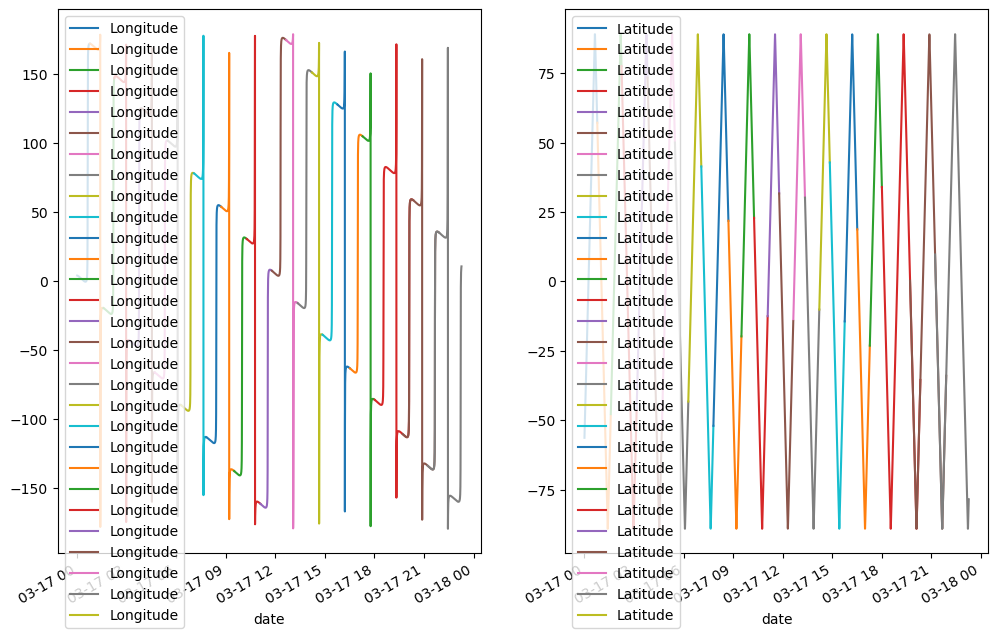

In [135]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

orbit_dfs = []

for s,e in orbits:
    orbit_dfs.append(df17.iloc[s:e])
    orbit_dfs[-1].plot(x='date', y='Longitude', ax=ax1)
    orbit_dfs[-1].plot(x='date', y='Latitude', ax=ax2)
    print(orbit_dfs[-1].date.min(),  orbit_dfs[-1].date.max())

In [176]:


# lats = df17.Latitude.unique()

2013-03-17 00:00:09 2013-03-17 01:24:49
2013-03-17 01:24:49 2013-03-17 02:11:39
2013-03-17 02:11:39 2013-03-17 02:58:19
2013-03-17 02:58:19 2013-03-17 03:44:59
2013-03-17 03:44:59 2013-03-17 04:31:39
2013-03-17 04:31:39 2013-03-17 05:18:29
2013-03-17 05:18:29 2013-03-17 06:05:09
2013-03-17 06:05:09 2013-03-17 06:51:59
2013-03-17 06:51:59 2013-03-17 07:38:39
2013-03-17 07:38:39 2013-03-17 08:25:19
2013-03-17 08:25:19 2013-03-17 09:11:59
2013-03-17 09:11:59 2013-03-17 09:58:49
2013-03-17 09:58:49 2013-03-17 10:45:29
2013-03-17 10:45:29 2013-03-17 11:32:19
2013-03-17 11:32:19 2013-03-17 12:18:49
2013-03-17 12:18:49 2013-03-17 13:05:39
2013-03-17 13:05:39 2013-03-17 13:52:19
2013-03-17 13:52:19 2013-03-17 14:39:09
2013-03-17 14:39:09 2013-03-17 15:25:49
2013-03-17 15:25:49 2013-03-17 16:12:39
2013-03-17 16:12:39 2013-03-17 16:59:09
2013-03-17 16:59:09 2013-03-17 17:45:59
2013-03-17 17:45:59 2013-03-17 18:32:39
2013-03-17 18:32:39 2013-03-17 19:19:29
2013-03-17 19:19:29 2013-03-17 20:06:09


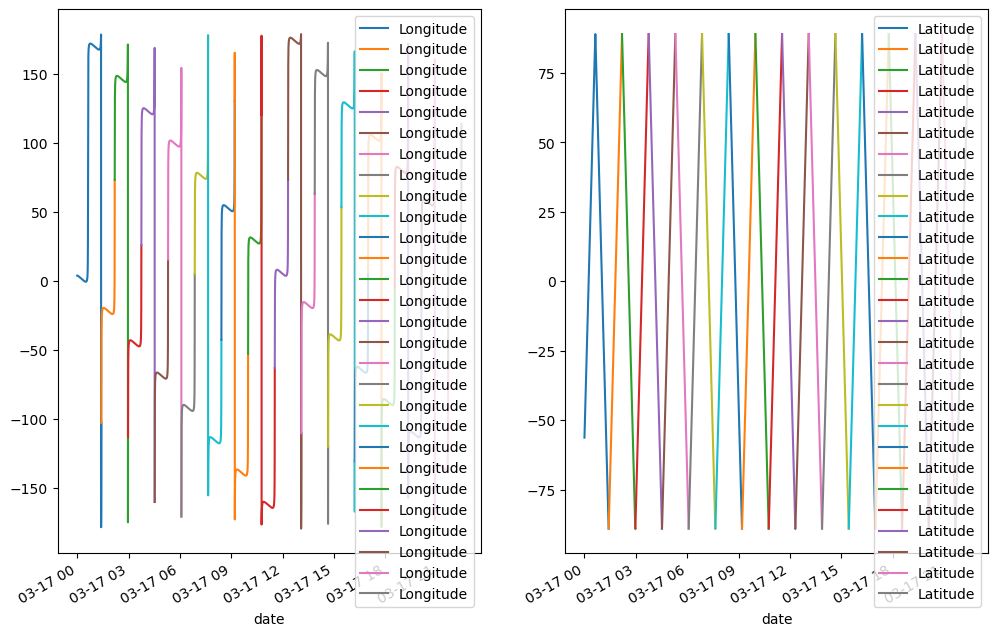

In [178]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

orbit_dfs = []

pt0 = 0

for split in peaks[1:-1]:
    
    
    orbit_dfs.append(df17.iloc[pt0:split])
    
    pt0 = split
    
    orbit_dfs[-1].plot(x='date', y='Longitude', ax=ax1)
    orbit_dfs[-1].plot(x='date', y='Latitude', ax=ax2)
    print(orbit_dfs[-1].date.min(),  orbit_dfs[-1].date.max())

<Axes: xlabel='date'>

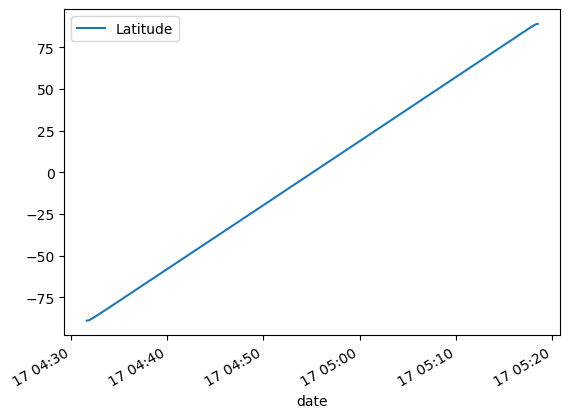

In [36]:
#orbits = [[3200, 5280], [5280, 6880],[6880, 8810], [8810, 10480], [10480, 12280], [12280, 14080], [14080,15780], [15780, 17780]]
nature = ['descending','ascending']*(c-1) # 0 means ascending and 1 means descending
#orbit_num = [1,1,2,2,3,3,4,4,5,5,6,6,7,7]

c_n = []
for i in range(32):
    c_n.append('gps_' + str(i+1) + '_X')
    c_n.append('gps_' + str(i+1) + '_Y')
    c_n.append('gps_' + str(i+1) + '_Z')
    c_n.append('gps_' + str(i+1) + '_stec')
    c_n.append('gps_' + str(i+1) + '_elev')
    c_n.append('gps_' + str(i+1) + '_interp_stec')

c_name = ['orbit', 'nature', 'time', 'grace_X', 'grace_Y', 'grace_Z'] + c_n
print(len(c_name))

date_t = np.unique(d17.date[orbits[0][0]:orbits[-1][1]].values)
t = len(date_t)
print(t)

print(np.unique(d17.PRN))
data_n = np.zeros((t+1, len(c_name)))
data_n = data_n.tolist()

for i in range(len(c_name)):
    data_n[0][i] = c_name[i]


for a, b, c in tqdm(zip(orbits, nature, orbit_num)):
    a1 , a2 = a
    
    subset = d17.sel(step=slice(a1, a2+1))
    print(a1, a2+1)
    d_n = list(subset.groupby('date'))
    
    for time, d in d_n:
        for tt in range(t):
            if time == date_t[tt]:
                
                for i in range(len(d.PRN.values)):
                    pc = (d.PRN.values[i])*6
                    
                    data_n[tt+1][pc] = d.GPS_Position_X.values[i]
                    data_n[tt+1][pc+1] = d.GPS_Position_Y.values[i]
                    data_n[tt+1][pc+2] = d.GPS_Position_Z.values[i]
                    data_n[tt+1][pc+3] = d.Absolute_STEC.values[i]
                    data_n[tt+1][pc+4] = d.Elevation_Angle.values[i]
                    #data_n[tt+1][pc+5] = sami_calculated_stec
                    
                    if data_n[tt+1][3] == 0:
                        data_n[tt+1][0] = c
                        data_n[tt+1][1] = b
                        data_n[tt+1][2] = time
                        data_n[tt+1][3] = d.LEO_Position_X.values[i]
                        data_n[tt+1][4] = d.LEO_Position_Y.values[i]
                        data_n[tt+1][5] = d.LEO_Position_Z.values[i]
                    
                break


print('done')

198
8128
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25 26
 28 29 30 31 32]


0it [00:00, ?it/s]

0 1739


1it [00:00,  2.25it/s]

1738 3695


2it [00:01,  1.86it/s]

3694 5400


3it [00:01,  1.61it/s]

5399 7225


4it [00:02,  1.37it/s]

7224 8963


5it [00:03,  1.21it/s]

8962 10884


6it [00:04,  1.10it/s]

10883 12667


7it [00:05,  1.01s/it]

12666 14496


8it [00:07,  1.10s/it]

14495 16330


9it [00:08,  1.19s/it]

16329 18111


10it [00:10,  1.31s/it]

18110 20128


11it [00:11,  1.43s/it]

20127 21889


12it [00:13,  1.62s/it]

21888 23756


13it [00:15,  1.72s/it]

23755 25541


14it [00:17,  1.82s/it]

25540 27271


15it [00:20,  1.93s/it]

27270 29071


16it [00:22,  2.05s/it]

29070 30797


17it [00:24,  2.16s/it]

30796 32830


18it [00:27,  2.29s/it]

32829 34371


19it [00:30,  2.40s/it]

34370 36295


20it [00:32,  2.53s/it]

36294 38047


21it [00:35,  2.64s/it]

38046 39936


22it [00:38,  2.77s/it]

39935 41536


23it [00:42,  2.89s/it]

41535 46707


24it [00:52,  2.18s/it]


46706 45129


ValueError: date must not be empty

In [39]:
data_n[0]

['orbit',
 'nature',
 'time',
 'grace_X',
 'grace_Y',
 'grace_Z',
 'gps_1_X',
 'gps_1_Y',
 'gps_1_Z',
 'gps_1_stec',
 'gps_1_elev',
 'gps_1_interp_stec',
 'gps_2_X',
 'gps_2_Y',
 'gps_2_Z',
 'gps_2_stec',
 'gps_2_elev',
 'gps_2_interp_stec',
 'gps_3_X',
 'gps_3_Y',
 'gps_3_Z',
 'gps_3_stec',
 'gps_3_elev',
 'gps_3_interp_stec',
 'gps_4_X',
 'gps_4_Y',
 'gps_4_Z',
 'gps_4_stec',
 'gps_4_elev',
 'gps_4_interp_stec',
 'gps_5_X',
 'gps_5_Y',
 'gps_5_Z',
 'gps_5_stec',
 'gps_5_elev',
 'gps_5_interp_stec',
 'gps_6_X',
 'gps_6_Y',
 'gps_6_Z',
 'gps_6_stec',
 'gps_6_elev',
 'gps_6_interp_stec',
 'gps_7_X',
 'gps_7_Y',
 'gps_7_Z',
 'gps_7_stec',
 'gps_7_elev',
 'gps_7_interp_stec',
 'gps_8_X',
 'gps_8_Y',
 'gps_8_Z',
 'gps_8_stec',
 'gps_8_elev',
 'gps_8_interp_stec',
 'gps_9_X',
 'gps_9_Y',
 'gps_9_Z',
 'gps_9_stec',
 'gps_9_elev',
 'gps_9_interp_stec',
 'gps_10_X',
 'gps_10_Y',
 'gps_10_Z',
 'gps_10_stec',
 'gps_10_elev',
 'gps_10_interp_stec',
 'gps_11_X',
 'gps_11_Y',
 'gps_11_Z',
 'gps_11_

In [14]:
filename = 'output.csv'

# Write the data to a CSV file
with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(data_n)

print(f"CSV file '{filename}' has been created.")

CSV file 'output.csv' has been created.


# Line of Sight TEC (LOSTEC)

In [64]:
'''
# Satellite passes - row number in output.csv
2 - 50, 186
3 - 451, 567 | 967, 1146

''';

GRACE lat lon alt -10.343174499410226 37.634148588814455 443.5115576979993
GPS lat lon alt -30.000797011075615 102.04891191665251 20337.194636074953
CSV file created


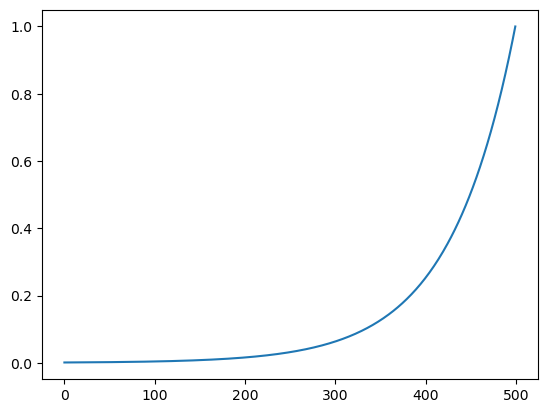

In [89]:
ecef_geodetic = il.reload(ecef_geodetic)
edens = []
lat_r = []
lon_r = []
alt_r = []
time_r = []
sep_r = []
index = []

prn = 3
col = prn*6

N = 500
num = np.geomspace(1e-3, 1, N)


#for i in range(50,186):
#for i in range(451, 568):
#for i in range(967, 1147):
#for i in range(2389, 2537):
#for i in range(2952, 3089):
for i in range(3519, 3651):
#for i in range(len(date_t)+1):
    if i != 0 and data_n[i][col] != 0:
        #print(i, data_n[i][col])
        
        t_i = data_n[i][2]
        l_x = data_n[i][3]
        l_y = data_n[i][4]
        l_z = data_n[i][5]
        g_x = data_n[i][col+0]
        g_y = data_n[i][col+1]
        g_z = data_n[i][col+2]
        
        #print(data_n[i][col+3], 'STEC value')
        del_x = g_x - l_x
        del_y = g_y - l_y
        del_z = g_z - l_z
        sp = np.sqrt(del_x**2 + del_y**2 + del_z**2)

        
        '''
        x_seq = np.geomspace(l_x,g_x,N)
        y_seq = np.geomspace(l_y,g_y,N)
        z_seq = np.geomspace(l_z,g_z,N)

        for x,y,z in zip(x_seq, y_seq, z_seq):
            lat_n, lon_n, alt_n = ecef_geodetic.ecef_to_lla(x, y, z)
            
            lat_r.append(lat_n)
            lon_r.append(lon_n)
            alt_r.append(alt_n/1000)
            time_r.append(t_i)
            index.append(i)
            sep_r.append(sp)
        '''
        
        
        for n in num:
            x = l_x + n*del_x
            y = l_y + n*del_y
            z = l_z + n*del_z
            
            lat_n, lon_n, alt_n = ecef_geodetic.ecef_to_lla(x, y, z)
            
            lat_r.append(lat_n)
            lon_r.append(lon_n)
            alt_r.append(alt_n/1000)
            time_r.append(t_i)
            index.append(i)
            sep_r.append(sp)



print('GRACE lat lon alt', lat_r[0], lon_r[0], alt_r[0])
print('GPS lat lon alt', lat_r[-1], lon_r[-1], alt_r[-1])

plt.plot(num)


# Creating the csv file

output_file = 'ray-coords.csv'

with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['lat', 'lon', 'alt'])
    writer.writerows(zip(lat_r, lon_r, alt_r))

print('CSV file created')

In [90]:
os.system("time python /home/pxv220016/prasoon/data/SAMI3-GITM-python/SAMI3_ESMF_Regrid.py /home/pxv220016/scratch/2013-03-17_SAMI '20130316' --cols edens --out_dir /home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/updated_sat_data/ray_tracing/20130316 --custom_input_file /home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/ray-coords.csv --ESMF_DIR /home/pxv220016/prasoon/data/SAMI3-GITM-python/esmf-8.4.0/apps/appsO/Linux.gfortran.64.openmpi.default/ --remake_files")

Generating interior points from SAMI outputs:  99%|█████████▊| 1454080/1474560 [00:28<00:00, 50830.19it/s]


Made custom mesh file
Found ESMF weight file, making it again...
calling ESMF...
Output:  Starting weight generation with these inputs: 
   Source File: /home/pxv220016/scratch/2013-03-17_SAMI/src_ugrid.nc
   Destination File: /home/pxv220016/scratch/2013-03-17_SAMI/dst_ugrid.nc
   Weight File: /home/pxv220016/scratch/2013-03-17_SAMI/esmf_weightfile.nc
   Source File is in UGRID format
   Source Grid is a global grid
   Source Grid is an unstructured grid
   Use the corner coordinates of the source grid to do the regrid
   Destination File is in UGRID format
   Destination Grid is a global grid
   Destination Grid is an unstructured grid
   Use the corner coordinates of the destination grid to do the regrid
   Regrid Method: bilinear
   Pole option: ALL
   Ignore unmapped destination points
   Line Type: greatcircle
   Norm Type: dstarea
   Extrap. Method: none

 Completed weight generation successfully.




Variable "time" not present in input file.
Output file will not contain satell

Writing edens 	 vars:(0/1)               : 100%|██████████| 596/596 [00:58<00:00, 10.14it/s]

real	2m31.252s
user	2m17.400s
sys	0m13.936s


0

# Interpolation

In [91]:
path = '/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/updated_sat_data/ray_tracing/20130316/edens_SAMI-REGRID.nc'
#sami = pd.read_csv(path, delimiter='\t')

'''
with open(path, 'rb') as file:
    sami = file.read()
    print(type(sami))
    for lines in sami:
        pass

print('done')
'''
sami = xr.open_dataset(path)
print(sami)

<xarray.Dataset> Size: 314MB
Dimensions:    (sat_step: 65500, sami_time: 596)
Coordinates:
  * sami_time  (sami_time) datetime64[ns] 5kB 2013-03-16 ... 2013-03-18T01:35:00
Dimensions without coordinates: sat_step
Data variables:
    lat        (sat_step) float64 524kB ...
    lon        (sat_step) float64 524kB ...
    alt        (sat_step) float64 524kB ...
    edens      (sami_time, sat_step) float64 312MB ...


In [92]:
print(time_r[0])
#print(sami.sami_time.dt.time.values)

#print(sami.alt.values)
#print(sami.sami_time.dt.day.values)
print(sami.lat[:10].values, sami.lon[:10].values, sami.alt[:10].values)

eden = []
for i in tqdm(range(len(time_r))):
    e = sami.edens.sel(sami_time=time_r[i], method='nearest')
    '''
    plt.scatter(sami.alt.values, e)
    plt.xlabel('Altitude')
    plt.ylabel('edens')
    plt.show()

    plt.plot(e)
    plt.show()

    plt.plot(sami.lat[:1000].values)
    break
    '''
    
    eden.append(e[i].values)
    
    if i < len(time_r) -1 and index[i] != index[i+1]:
        
        tec = sum(eden[:-1])
        

        num_s = sep_r[i]*num
        
        stec = 0
        for j in range(len(num)-1):
            s = num_s[j+1] - num_s[j]
            stec += s*(eden[j] + eden[j+1])*0.5*1e6

                
        stec = stec/1e16
        
        #stec = tec*sep_r[i]/((N-1)*1e16)*1e6
        
        #print(stec)
        data_n[index[i]][col+5] = stec
        eden = []


    
#print(e.values)


2013-03-17T09:46:20.000000000
[-10.3431745  -10.34484446 -10.34653764 -10.34825435 -10.34999494
 -10.35175972 -10.35354903 -10.35536321 -10.35720262 -10.35906759] [37.63414859 37.63635334 37.63858879 37.64085536 37.64315349 37.64548361
 37.64784618 37.65024164 37.65267046 37.65513308] [443.5115577  443.6006083  443.69091609 443.78249902 443.87537534
 443.96956353 444.06508238 444.16195092 444.26018848 444.35981467]


100%|████████████████████████████████████| 65500/65500 [01:31<00:00, 712.16it/s]


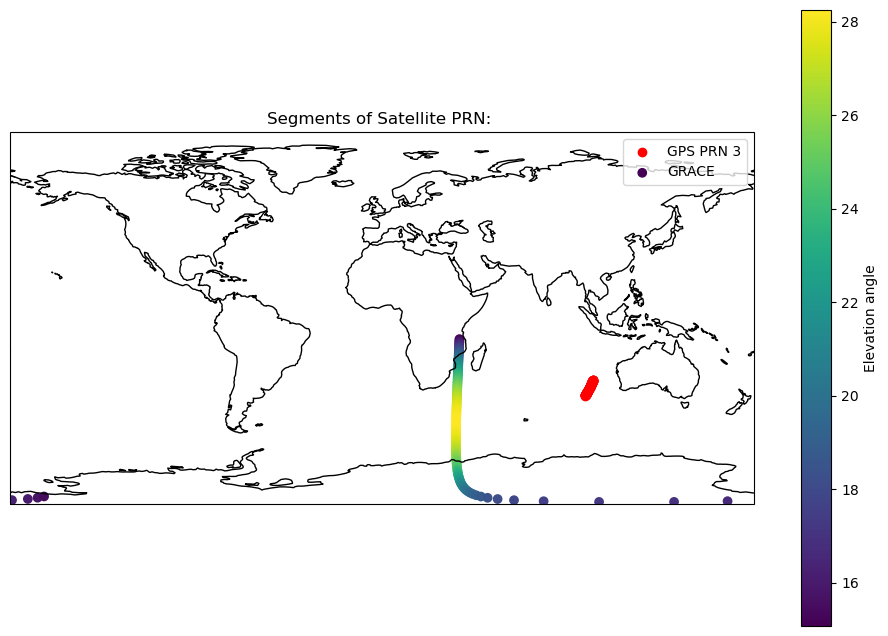

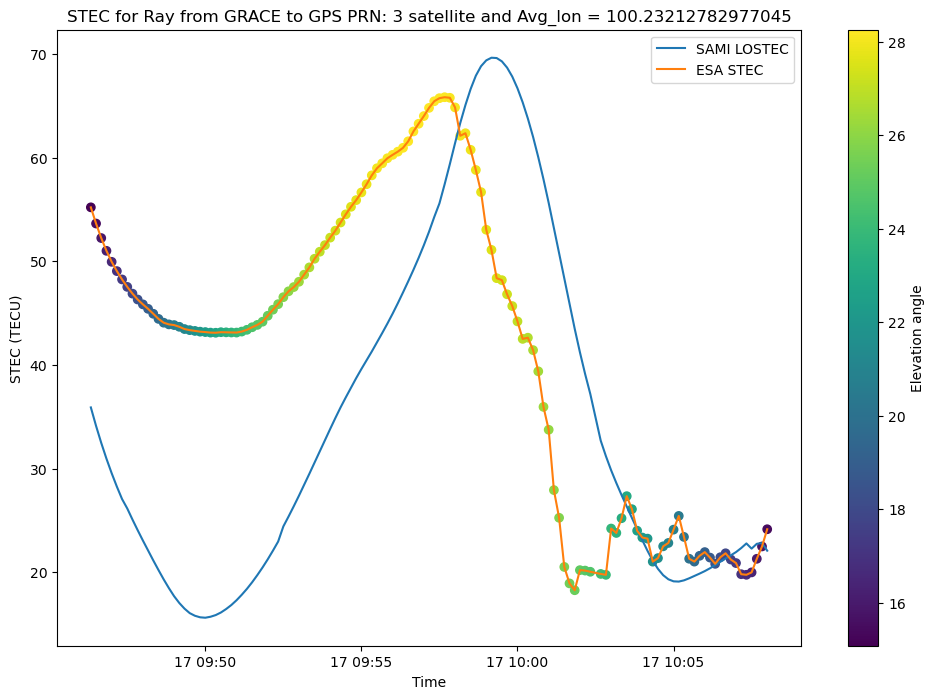

In [143]:
from ecef_geodetic import ecef_to_lla 

time_stec = []
stec_sami = []
stec_esa = []
lat_stec = []
lon_stec = []
stec_elev = []
lat_grace = []
lon_grace = []

col = prn*6

#for i in range(50, 185):
#for i in range(451, 567):
#for i in range(967, 1146):
#for i in range(2389, 2536):
#for i in range(2952, 3088):
for i in range(3519, 3650):
    if data_n[i][col+5] != 0:
        time_stec.append(data_n[i][2])
        stec_sami.append(data_n[i][col+5])
        stec_esa.append(data_n[i][col+3])
        stec_elev.append(data_n[i][col+4])
        
        la, lo, al = ecef_to_lla(data_n[i][col], data_n[i][col+1], data_n[i][col+2])
        lat_stec.append(la)
        lon_stec.append(lo)
        
    
        la_g, lo_g, al_g = ecef_to_lla(data_n[i][3], data_n[i][4], data_n[i][5])
        lat_grace.append(la_g)
        lon_grace.append(lo_g)
#print(lon_grace)

#print(time_stec)
#print(stec_sami)

plt.figure(figsize=(12,8))
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.scatter(lon_stec, lat_stec, label = 'GPS PRN ' + str(prn), c = 'red')
scatter = ax.scatter(lon_grace, lat_grace, label = 'GRACE', c = stec_elev)
cbar = plt.colorbar(scatter, ax=ax, orientation = 'vertical')
cbar.set_label('Elevation angle')
ax.coastlines()
plt.legend()
plt.title('Segments of Satellite PRN: ' )
plt.show()



avg_lon = sum(lon_stec)/len(lon_stec)


plt.figure(figsize=(12,8))
plt.plot(time_stec, stec_sami, label='SAMI LOSTEC')
plt.plot(time_stec, stec_esa, label='ESA STEC')
scatter = plt.scatter(time_stec, stec_esa, c = stec_elev)
cbar = plt.colorbar(scatter, orientation = 'vertical')
cbar.set_label('Elevation angle')
plt.legend()
plt.title('STEC for Ray from GRACE to GPS PRN: ' + str(prn) + ' satellite and Avg_lon = ' + str(avg_lon))
plt.ylabel('STEC (TECU)')
plt.xlabel('Time')



'''
plt.figure(figsize=(12,8))
plt.plot(lat_stec, stec_sami, label='SAMI LOSTEC')
plt.plot(lat_stec, stec_esa, label='ESA STEC')
scatter = plt.scatter(lat_stec, stec_esa, c = stec_elev)
cbar = plt.colorbar(scatter, orientation = 'vertical')
cbar.set_label('Elevation angle')
plt.legend()
plt.title('STEC for Ray from GRACE to GPS PRN: ' + str(prn) + ' satellite and Avg_lon = ' + str(avg_lon))
plt.ylabel('STEC (TECU)')
plt.xlabel('Latitude')
''';

In [113]:
filename = '5March_output.csv'

# Write the data to a CSV file
with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(data_n)

print(f"CSV file '{filename}' has been created.")

CSV file '5March_output.csv' has been created.


In [110]:
sep = 23205596.82373721
l = len(e)
print(l)

print(sum(e.values)*sep)

tec = sum(e.values[:-1])*sep/((l-1)*1e16)
print(tec)

10000
1501242683919327.5
1.5013885507410396e-05
